In [4]:


import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

ticker = "^NSEBANK"  # Yahoo Finance ticker for Bank Nifty
start_date = "2024-01-01"
end_date = "2025-02-28"
window_size = 10       
test_size = 0.2         
num_epochs = 50
learning_rate = 1e-3
patience = 10 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Download historical data
data = yf.download(ticker, start=start_date, end=end_date, interval="60m")
data.head(5)


Using device: cpu
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^NSEBANK,^NSEBANK,^NSEBANK,^NSEBANK,^NSEBANK
Datetime,,,,,
2024-01-01 03:45:00+00:00,48250.500000,48315.000000,48135.898438,48203.449219,0
2024-01-01 04:45:00+00:00,48332.500000,48367.148438,48220.050781,48249.000000,0
2024-01-01 05:45:00+00:00,48354.800781,48361.148438,48287.550781,48329.199219,0
2024-01-01 06:45:00+00:00,48307.699219,48362.199219,48275.300781,48350.949219,0
2024-01-01 07:45:00+00:00,48357.000000,48369.898438,48283.500000,48311.199219,0


In [6]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Compute Moving Averages
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
# Compute RSI (Relative Strength Index)
def compute_rsi(prices, window=14):
    delta = prices.diff()
    gain = delta.clip(lower=0).rolling(window=window).mean()
    loss = (-delta.clip(upper=0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
data['RSI'] = compute_rsi(data['Close'], window=14)
# Compute Volatility: 10-day rolling standard deviation of Close price
data['Volatility'] = data['Close'].rolling(window=10).std()
# Compute Log Returns (to capture relative changes)
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)
print("Enhanced Data Sample:")
data.head()

Enhanced Data Sample:


Price,Open,High,Low,Close,Volume,MA10,MA20,MA50,RSI,Volatility,LogReturn
Ticker,^NSEBANK,^NSEBANK,^NSEBANK,^NSEBANK,^NSEBANK,,,,,,
Datetime,,,,,,,,,,,
2024-01-19 03:45:00+00:00,46103.500000,46180.699219,46024.851562,46109.449219,0,45911.674609,46618.720117,47256.103203,34.037573,201.746949,0.007564
2024-01-19 04:45:00+00:00,46111.851562,46248.648438,45904.699219,45930.148438,0,45892.474609,46504.512500,47228.347188,36.240741,188.170175,-0.003896
2024-01-19 05:45:00+00:00,45925.949219,46048.050781,45850.199219,45912.250000,0,45875.349609,46393.982422,47201.084219,39.666256,176.269946,-0.000390
2024-01-19 06:45:00+00:00,45906.550781,45920.050781,45834.398438,45912.148438,0,45888.474609,46282.024805,47174.055156,41.817687,173.317409,-0.000002
2024-01-19 07:45:00+00:00,45909.000000,45944.050781,45593.800781,45595.800781,0,45848.744531,46155.547266,47140.784141,34.984817,191.275455,-0.006914


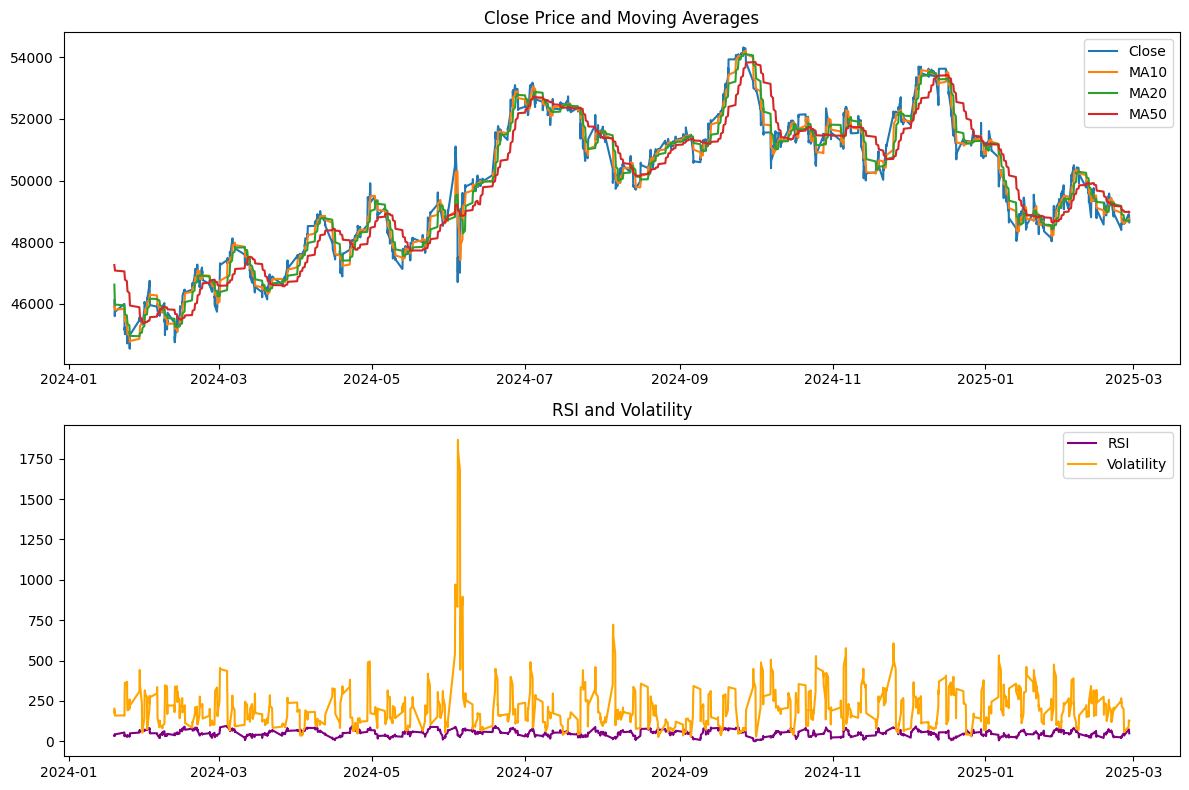

In [7]:
# Plot the computed features for inspection
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(data.index, data['Close'], label='Close')
plt.plot(data.index, data['MA10'], label='MA10')
plt.plot(data.index, data['MA20'], label='MA20')
plt.plot(data.index, data['MA50'], label='MA50')
plt.title("Close Price and Moving Averages")
plt.legend()

plt.subplot(2,1,2)
plt.plot(data.index, data['RSI'], label='RSI', color='purple')
plt.plot(data.index, data['Volatility'], label='Volatility', color='orange')
plt.title("RSI and Volatility")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
features = data[['Close', 'MA10', 'RSI', 'LogReturn']].values.astype(np.float32)

# Normalize each feature independently using MinMaxScaler
scalers = {}
features_scaled = features.copy()
for i in range(features.shape[1]):
    scaler = MinMaxScaler(feature_range=(0, 1))
    features_scaled[:, i:i+1] = scaler.fit_transform(features[:, i:i+1])
    scalers[i] = scaler

def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data[i+window_size, 0])
    return np.array(sequences), np.array(labels)

X, y = create_sequences(features_scaled, window_size)
print("Shape of X:", X.shape)  
print("Shape of y:", y.shape)

Shape of X: (1901, 10, 4)
Shape of y: (1901,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)


c:\Users\ashwi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Improved Transformer Model:
TransformerModel(
  (input_linear): Linear(in_features=4, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/50], Loss: 0.066782
Epoch [20/50], Loss: 0.091353
Epoch [30/

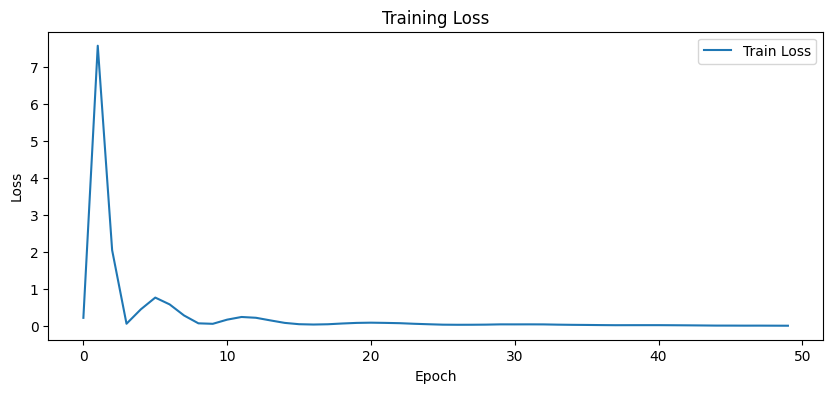

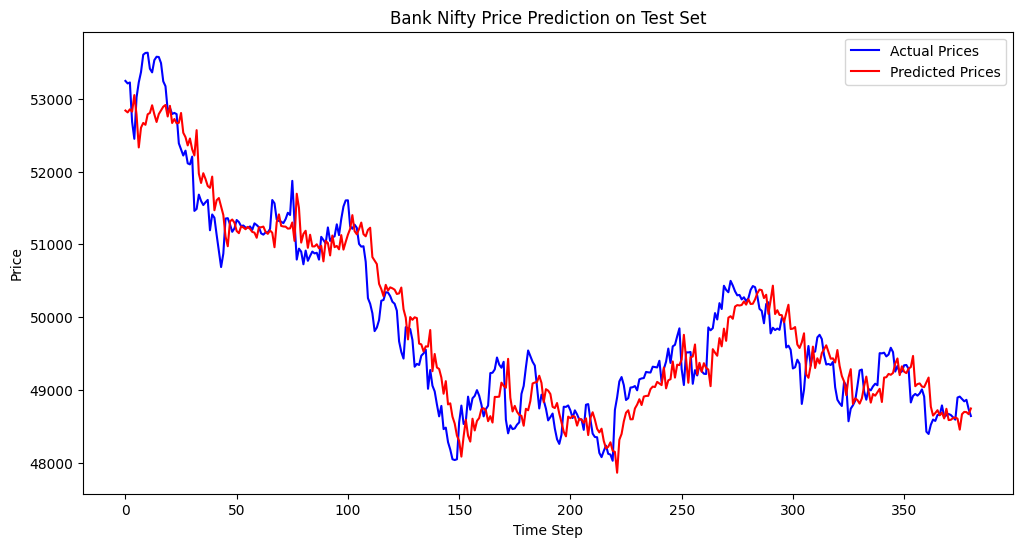

Mean Absolute Error: 305.49
Root Mean Squared Error: 390.66


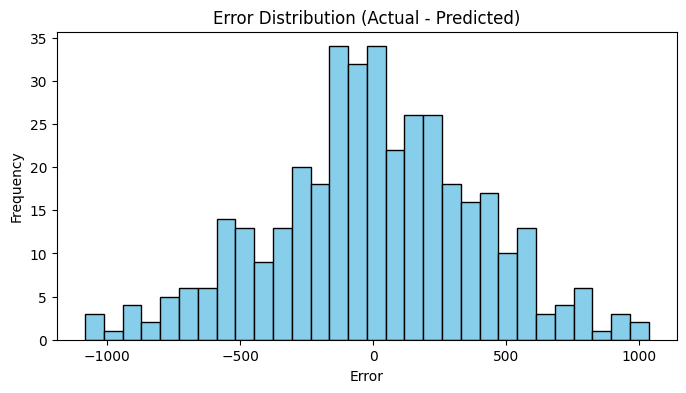

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_linear = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(model_dim, output_dim)
        
    def forward(self, x):
        proj = self.input_linear(x)  # (batch, seq_len, model_dim)
        # Save the last time step of the projection for residual connection
        residual = proj[:, -1, :]    # (batch, model_dim)
        # Transformer expects input shape: (seq_len, batch, model_dim)
        x_trans = proj.transpose(0, 1)  # (seq_len, batch, model_dim)
        encoded = self.transformer_encoder(x_trans)  # (seq_len, batch, model_dim)
        # Get the output from the last time step of the encoder
        x_last = encoded[-1, :, :]   # (batch, model_dim)
        x_last = self.dropout(x_last)
        # Add residual connection to help preserve variance
        x_final = x_last + residual
        output = self.fc(x_final)    # (batch, output_dim)
        return output

# Set model parameters
input_dim = features.shape[1]  # 4 features: Close, MA10, RSI, LogReturn
model_dim = 64
num_heads = 4
num_layers = 2
output_dim = 1

model = TransformerModel(input_dim, model_dim, num_heads, num_layers, output_dim, dropout=0.1).to(device)
print("Improved Transformer Model:")
print(model)

# ## Train the Model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Evaluate the Model on Test Set
# Evaluation
model.eval()
with torch.no_grad():
    test_preds = model(X_test).cpu().numpy()

# Inverse transform predictions and actual values using the scaler for the "Close" feature 
close_scaler = scalers[0]
test_preds_actual = close_scaler.inverse_transform(test_preds)
y_test_actual = close_scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices", color='blue')
plt.plot(test_preds_actual, label="Predicted Prices", color='red')
plt.title("Bank Nifty Price Prediction on Test Set")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()

# Compute Error Metrics
errors = y_test_actual - test_preds_actual
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

plt.figure(figsize=(8,4))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title("Error Distribution (Actual - Predicted)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

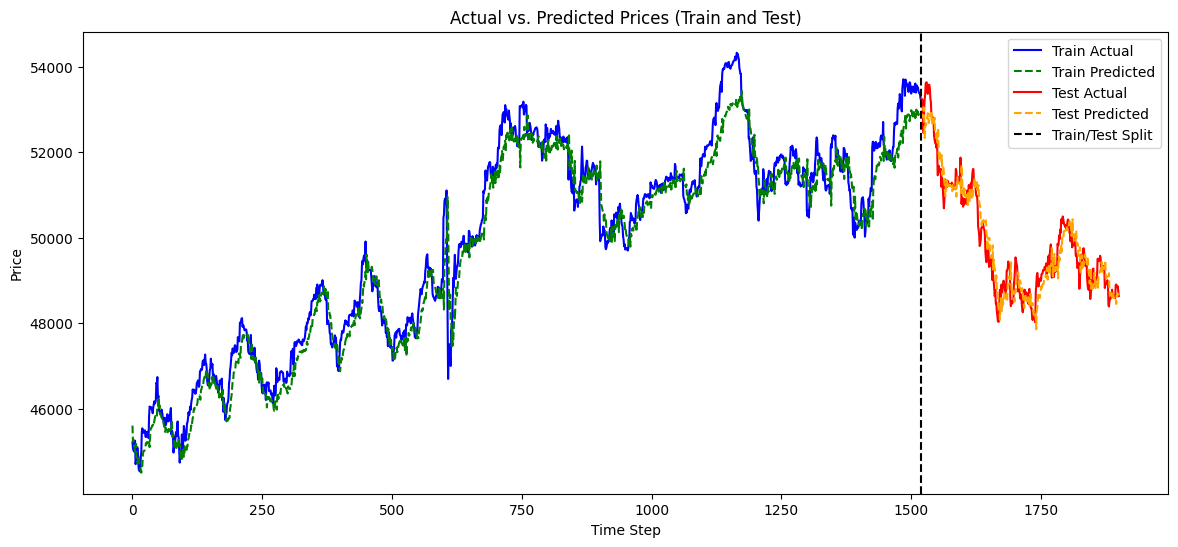

In [11]:
# Evaluate on Training Set
model.eval()
with torch.no_grad():
    train_preds = model(X_train).cpu().numpy()

train_preds_actual = close_scaler.inverse_transform(train_preds)
y_train_actual = close_scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1))

# Evaluate on Test Set
with torch.no_grad():
    test_preds = model(X_test).cpu().numpy()

test_preds_actual = close_scaler.inverse_transform(test_preds)
y_test_actual = close_scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

# Create index arrays for plotting
train_index = np.arange(len(y_train_actual))
test_index = np.arange(len(y_test_actual)) + len(y_train_actual)

# Plot on a single graph
plt.figure(figsize=(14,6))
plt.plot(train_index, y_train_actual, label="Train Actual", color="blue")
plt.plot(train_index, train_preds_actual, label="Train Predicted", color="green", linestyle="--")
plt.plot(test_index, y_test_actual, label="Test Actual", color="red")
plt.plot(test_index, test_preds_actual, label="Test Predicted", color="orange", linestyle="--")
plt.axvline(x=len(y_train_actual)-1, color='black', linestyle='--', label="Train/Test Split")
plt.title("Actual vs. Predicted Prices (Train and Test)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()
